MNIST Conditional GAN

# Conditional GANs

Based on the excellent tutorial [here](https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb).

By formulating the process as a two-player game, Generative Adversarial Networks (GANs) can be very effective in generating realistic content. However, we may want to have more control over what is generated. Conditional GANs offer more control by letting us specify the *class* of output we want. Then we hand the generated content and the class it's supposed to be to the discriminator. The disciminator attempts to differentiate between the generated content of a certain class and the real content of a certain class.

The original paper that described conditional GANs is [here](https://arxiv.org/abs/1411.1784).

![](https://salu133445.github.io/dan/figs/cgan.png)


## Libaries

As always, we load lots of libraries.

In [14]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Data

For this demo, we will be using the MNIST data set. We can apply GANs to other datasets but the training process takes much longer. Our goal will be to supply random noise and a class label (e.g. a digit between 0 and 9) to the generator and produce an image of that particular digit.

In [15]:
# A transform to convert the images to tensor and normalize their RGB values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)

data = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

## Helper Functions

We'll need several helper functions for training the conditional GAN. The first converts labels to one hot encoded vectors, we will use it to pass the desired label to the generator. The second will plot a grid of 10x10 images from the generator.

In [16]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [17]:
to_onehot(3)

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [18]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

## Architecture

We now instantiate the generator and discriminator architectures. The generator takes a random noise vector and a one hot encoded label as input and produces an image. The discriminator takes an image and a one hot encoded label as input and produces a single value between 0 and 1. The discriminator is trained to output 1 for real images and 0 for fake images. The generator is trained to fool the discriminator by outputting images that look real.

In [19]:
class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=10, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 128), # auxillary dimension for label
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [20]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_classes=10, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        return y_

## Set up and Training

Now, we're ready to instantiate our models, hyperparameters, and optimizers. Since the task is so easy for MNIST, we will train for only 10 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other.

In [21]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE) # randomly intialized
G = Generator().to(DEVICE) # randomly initialized

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
all_ones = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [22]:
images, class_labels = next(iter(data_loader))
class_labels_encoded = class_labels.view(batch_size, 1)
class_labels_encoded = to_onehot(class_labels_encoded).to(DEVICE)
print(class_labels[:10])
print(class_labels_encoded[:10])

tensor([4, 8, 1, 5, 0, 4, 8, 2, 5, 1])
tensor([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


In [10]:
# a directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, class_labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        class_labels = class_labels.view(batch_size, 1) # add singleton dimension so batch_size x 1
        class_labels = to_onehot(class_labels).to(DEVICE)
        x_outputs = D(x, class_labels) # input includes labels
        D_x_loss = criterion(x_outputs, all_ones) # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, class_labels), class_labels) # input to both generator and discriminator includes labels
        D_z_loss = criterion(z_outputs, all_zeros) # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, class_labels), class_labels)
        G_loss = -1 * criterion(z_outputs, all_zeros) # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.395571231842041, G Loss: -0.691758394241333
Epoch: 0/10, Step: 500, D Loss: 1.0961824655532837, G Loss: -0.44526758790016174
Epoch: 1/10, Step: 1000, D Loss: 1.039373755455017, G Loss: -0.2498992681503296
Epoch: 1/10, Step: 1500, D Loss: 1.2127230167388916, G Loss: -0.7997499108314514
Epoch: 2/10, Step: 2000, D Loss: 1.1976568698883057, G Loss: -0.5237036943435669
Epoch: 2/10, Step: 2500, D Loss: 1.0645639896392822, G Loss: -0.604216456413269
Epoch: 3/10, Step: 3000, D Loss: 1.2835071086883545, G Loss: -0.6310629844665527
Epoch: 3/10, Step: 3500, D Loss: 1.5267739295959473, G Loss: -0.2976498603820801
Epoch: 4/10, Step: 4000, D Loss: 1.3138728141784668, G Loss: -0.5189226865768433
Epoch: 4/10, Step: 4500, D Loss: 1.425218105316162, G Loss: -0.8295738697052002
Epoch: 5/10, Step: 5000, D Loss: 1.2697324752807617, G Loss: -0.6327874660491943
Epoch: 5/10, Step: 5500, D Loss: 1.316536784172058, G Loss: -0.5923196077346802
Epoch: 6/10, Step: 6000, D Loss: 1.35

Now let's plot these images. At first, the generator just produces noise (as we expect).

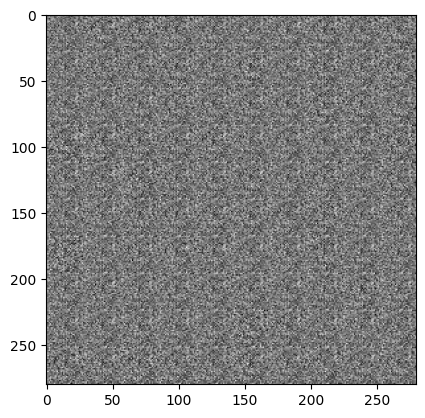

In [11]:
img = mpimg.imread('samples/ConditionalGAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

But then it gets better.

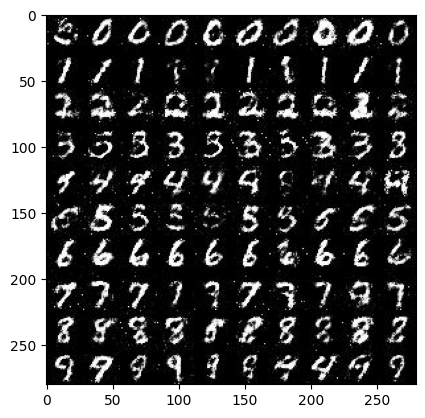

In [12]:
img = mpimg.imread('samples/ConditionalGAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

In fact, if we don't look too closely, we can recognize the numbers it produces.

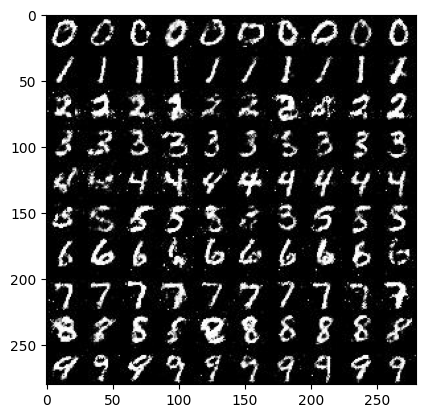

In [13]:
img = mpimg.imread('samples/ConditionalGAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

And by the time we're done training, even the worst images look like messy handwriting!